In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pygam import PoissonGAM, s,f, GAM, InvGaussGAM, te, l

# Load bike rental data with station information CSV file
bike_dat_raw = pd.read_csv("seoul_bike_rental_data_processed_2406.csv", encoding="cp949")

# Check the shape of processed data
bike_dat_raw.shape

(4984352, 29)

In [3]:
# Check irregular rides of 0 minutes used or 0 meters riden, Exclude them.
print((bike_dat_raw['use_meters']==0).value_counts())
print()
print((bike_dat_raw['use_minutes']==0).value_counts())

bike_dat = bike_dat_raw[(bike_dat_raw['use_meters']!=0) & (bike_dat_raw['use_minutes']!=0)].copy()
print()
print(bike_dat.shape)

False    4752525
True      231827
Name: use_meters, dtype: int64

False    4861062
True      123290
Name: use_minutes, dtype: int64

(4740293, 29)


In [4]:
# Add numeric forms of station IDs
station_id_num = np.concatenate([bike_dat['rent_station_id'].drop_duplicates(), bike_dat['return_station_id'].drop_duplicates()])
station_id_num = pd.Series(station_id_num).drop_duplicates().astype('category')
station_id_num = pd.DataFrame({'station_id': station_id_num, 'station_id_num': station_id_num.cat.codes})

bike_dat = bike_dat.merge(station_id_num.rename(columns={'station_id': 'rent_station_id', 'station_id_num': 'rent_station_id_num'}), how = 'left', on = 'rent_station_id')
bike_dat = bike_dat.merge(station_id_num.rename(columns={'station_id': 'return_station_id', 'station_id_num': 'return_station_id_num'}), how = 'left', on = 'return_station_id')

# Convert rent_is_weekend to numeric
bike_dat['rent_is_weekend'] = bike_dat['rent_is_weekend'].astype(int)
bike_dat['return_is_weekend'] = bike_dat['return_is_weekend'].astype(int)

In [6]:
# Calculate hourly bike rentals for each station 
hourly_rent_counts = bike_dat.groupby(['rent_station_id_num', 'rent_station_latitude', 'rent_station_longitude', 'rent_date', 'rent_is_weekend', 'rent_weekday', 'rent_hour'], as_index=False).size().rename(columns={'size': 'num_rent'})

# Add past 7-day rolling averages of hourly bike rentals for each station
daily_rent_counts = hourly_rent_counts.groupby(['rent_station_id_num', 'rent_is_weekend', 'rent_date', 'rent_hour'])['num_rent'].sum().reset_index()
daily_rent_counts = daily_rent_counts.sort_values(['rent_station_id_num', 'rent_date'])
daily_rent_counts['num_rent_rolling_7'] = (
    daily_rent_counts.groupby(['rent_station_id_num', 'rent_hour'])['num_rent']
    .transform(lambda x: x.rolling(7, min_periods=1).mean().shift(1)))

hourly_rent_counts = hourly_rent_counts.merge(
    daily_rent_counts[['rent_station_id_num', 'rent_date', 'rent_hour', 'num_rent_rolling_7']],
    how='left',
    on=['rent_station_id_num','rent_date', 'rent_hour'])

hourly_rent_counts = hourly_rent_counts[hourly_rent_counts['num_rent_rolling_7'].isnull()==False]

In [11]:
# Train model with first three-week data, validate it on the last week data
hourly_rent_counts_train = hourly_rent_counts[hourly_rent_counts['rent_date'] < '2024-06-24'].copy()
hourly_rent_counts_test = hourly_rent_counts[hourly_rent_counts['rent_date'] >= '2024-06-24'].copy()

#display(hourly_rent_counts_train[(hourly_rent_counts_train['rent_station_id_num']==2739) & (hourly_rent_counts_train['rent_hour']==16)])
display(hourly_rent_counts_train)
display(hourly_rent_counts_test)

rent_station_id_num  rent_station_latitude  rent_station_longitude  \
19                         0              37.552746              126.918617   
20                         0              37.552746              126.918617   
25                         0              37.552746              126.918617   
26                         0              37.552746              126.918617   
27                         0              37.552746              126.918617   
...                      ...                    ...                     ...   
1216208                 2739              37.534390              126.869598   
1216209                 2739              37.534390              126.869598   
1216210                 2739              37.534390              126.869598   
1216211                 2739              37.534390              126.869598   
1216212                 2739              37.534390              126.869598   

          rent_date  rent_is_weekend  rent_weekday  rent_hour  num_rent  \
19       2024-06-02                1             6          0         3   
20       2024-06-02                1             6          1         2   
25       2024-06-02                1             6          8         1   
26       2024-06-02                1             6          9         1   
27       2024-06-02                1             6         10         3   
...             ...              ...           ...        ...       ...   
1216208  2024-06-23                1             6         19         8   
1216209  2024-06-23                1             6         20         4   
1216210  2024-06-23                1             6         21         5   
1216211  2024-06-23                1             6         22         1   
1216212  2024-06-23                1             6         23         2   

         num_rent_rolling_7  
19                 2.000000  
20                 1.000000  
25                 1.000000  
26                 1.000000  
27                 6.000000  
...                     ...  
1216208            9.000000  
1216209           10.142857  
1216210           11.142857  
1216211            6.428571  
1216212            4.571429  

[873914 rows x 9 columns]

rent_station_id_num  rent_station_latitude  rent_station_longitude  \
433                        0              37.552746              126.918617   
434                        0              37.552746              126.918617   
435                        0              37.552746              126.918617   
436                        0              37.552746              126.918617   
437                        0              37.552746              126.918617   
...                      ...                    ...                     ...   
1216362                 2739              37.534390              126.869598   
1216363                 2739              37.534390              126.869598   
1216364                 2739              37.534390              126.869598   
1216365                 2739              37.534390              126.869598   
1216366                 2739              37.534390              126.869598   

          rent_date  rent_is_weekend  rent_weekday  rent_hour  num_rent  \
433      2024-06-24                0             0          0         3   
434      2024-06-24                0             0          1         7   
435      2024-06-24                0             0          2         2   
436      2024-06-24                0             0          7         2   
437      2024-06-24                0             0          8         1   
...             ...              ...           ...        ...       ...   
1216362  2024-06-30                1             6         19        13   
1216363  2024-06-30                1             6         20         4   
1216364  2024-06-30                1             6         21         5   
1216365  2024-06-30                1             6         22         8   
1216366  2024-06-30                1             6         23         4   

         num_rent_rolling_7  
433                2.285714  
434                2.571429  
435                1.285714  
436                1.285714  
437                1.857143  
...                     ...  
1216362           10.714286  
1216363            8.285714  
1216364            8.285714  
1216365            6.000000  
1216366            6.571429  

[277995 rows x 9 columns]

In [13]:
# GAM with Poisson distribution of response variables, hourly bike rentals
# interactions between latitudes and longitudes of stations
# factor term of weekends or not
# smoothing terms of hours and 7-day rolling averages of bike rentals

gam_rent = PoissonGAM(te(0,1) + s(2) + s(3) + s(3, by=2) + s(4))
gam_rent.fit(hourly_rent_counts_train[['rent_station_latitude', 'rent_station_longitude', 'rent_weekday', 'rent_hour', 'num_rent_rolling_7']], hourly_rent_counts_train['num_rent'])

gam_rent.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    118.9505
Link Function:                          LogLink Log Likelihood:                              -1798791.6452
Number of Samples:                       873914 AIC:                                          3597821.1913
                                                AICc:                                         3597821.2245
                                                UBRE:                                               3.2228
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6416
Feature Function                  Lam

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25736\1620120484.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_rent.summary()


In [15]:
# Make predictions on the test set
hourly_rent_counts_test['rent_pred'] = gam_rent.predict(hourly_rent_counts_test[['rent_station_latitude', 'rent_station_longitude', 'rent_weekday', 'rent_hour', 'num_rent_rolling_7']])
hourly_rent_counts_test['residual'] = hourly_rent_counts_test['num_rent'] - hourly_rent_counts_test['rent_pred']

hourly_rent_counts_test = hourly_rent_counts_test.rename(columns={'rent_station_id_num': 'station_id_num', 'rent_hour':'hour', 'rent_station_latitude':'latitude', 'rent_station_longitude':'longitude'})

hourly_rent_counts_test

station_id_num   latitude   longitude   rent_date  rent_is_weekend  \
433                   0  37.552746  126.918617  2024-06-24                0   
434                   0  37.552746  126.918617  2024-06-24                0   
435                   0  37.552746  126.918617  2024-06-24                0   
436                   0  37.552746  126.918617  2024-06-24                0   
437                   0  37.552746  126.918617  2024-06-24                0   
...                 ...        ...         ...         ...              ...   
1216362            2739  37.534390  126.869598  2024-06-30                1   
1216363            2739  37.534390  126.869598  2024-06-30                1   
1216364            2739  37.534390  126.869598  2024-06-30                1   
1216365            2739  37.534390  126.869598  2024-06-30                1   
1216366            2739  37.534390  126.869598  2024-06-30                1   

         rent_weekday  hour  num_rent  num_rent_rolling_7  rent_pred  residual  
433                 0     0         3            2.285714   1.979737  1.020263  
434                 0     1         7            2.571429   1.982103  5.017897  
435                 0     2         2            1.285714   1.284577  0.715423  
436                 0     7         2            1.285714   3.272512 -1.272512  
437                 0     8         1            1.857143   3.968693 -2.968693  
...               ...   ...       ...                 ...        ...       ...  
1216362             6    19        13           10.714286   8.767640  4.232360  
1216363             6    20         4            8.285714   7.392504 -3.392504  
1216364             6    21         5            8.285714   7.085903 -2.085903  
1216365             6    22         8            6.000000   5.040052  2.959948  
1216366             6    23         4            6.571429   5.529166 -1.529166  

[277995 rows x 11 columns]

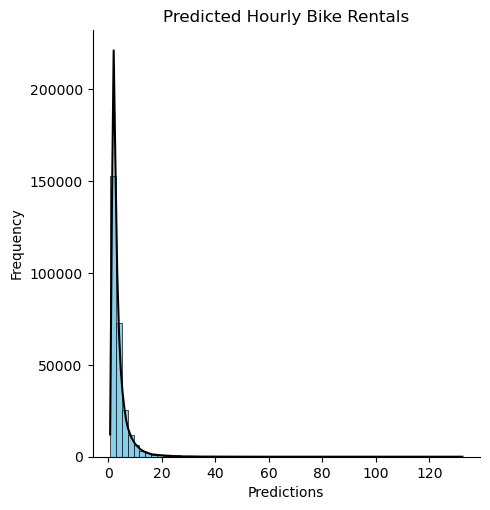

In [17]:
# 10. Distribution of predicted hourly bike rentals for the last week of June 2024

sns.displot(hourly_rent_counts_test['rent_pred'], kde=True, bins = 60, color="black", facecolor='skyblue')

plt.title("Predicted Hourly Bike Rentals")
plt.xlabel("Predictions")
plt.ylabel("Frequency")

plt.savefig('images/10_distribution_predicted_hourly_bike_rentals.png', bbox_inches='tight')
plt.show()

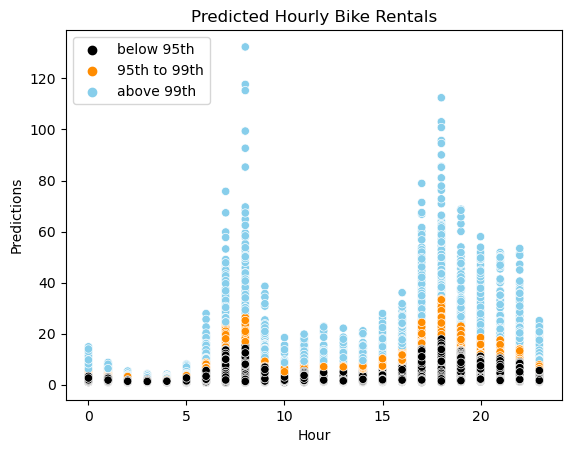

In [18]:
# 11. Predicted hourly bike rentals for the last week of June 2024

hourly_rent_counts_test['quantile_95'] = hourly_rent_counts_test['hour'].map(hourly_rent_counts_test.groupby(['hour'])['rent_pred'].quantile(0.95))
hourly_rent_counts_test['quantile_99'] = hourly_rent_counts_test['hour'].map(hourly_rent_counts_test.groupby(['hour'])['rent_pred'].quantile(0.99))

# Define a custom function to assign quantile groups
def assign_quantile_group(row):
    if row['rent_pred'] <= row['quantile_95']:
        return 'below 95th'
    elif row['rent_pred'] <= row['quantile_99']:
        return '95th to 99th'
    else:
        return 'above 99th'

hourly_rent_counts_test['quantile_range'] = hourly_rent_counts_test.apply(assign_quantile_group, axis=1)

sns.scatterplot(data=hourly_rent_counts_test, x='hour', y='rent_pred', hue='quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'})

plt.title("Predicted Hourly Bike Rentals")
plt.xlabel("Hour")
plt.ylabel("Predictions")
plt.legend(loc='upper left')

plt.savefig('images/11_predicted_hourly_bike_rentals.png', bbox_inches='tight')
plt.show()

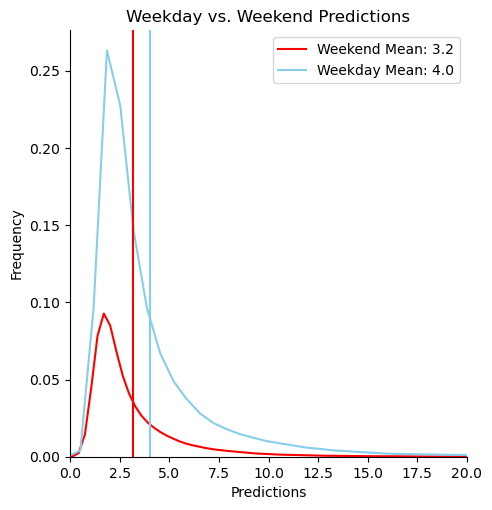

In [20]:
# 12. Weekday vs. Weekend predicted hourly bike rental

weekend_mean = hourly_rent_counts_test[hourly_rent_counts_test['rent_is_weekend'] == 1]['rent_pred'].mean()
weekday_mean = hourly_rent_counts_test[hourly_rent_counts_test['rent_is_weekend'] == 0]['rent_pred'].mean()

sns.displot(data=hourly_rent_counts_test, x="rent_pred", hue="rent_is_weekend", kind="kde", palette={1: 'red', 0: 'skyblue'}, legend=False)

plt.xlim(0,20)
plt.axvline(weekend_mean, color='red',  label=f'Weekend Mean: {weekend_mean:.1f}')
plt.axvline(weekday_mean, color='skyblue',  label=f'Weekday Mean: {weekday_mean:.1f}')

plt.title("Weekday vs. Weekend Predictions")
plt.xlabel("Predictions")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

plt.savefig('images/12_weekday_vs_weekend_predictions.png', bbox_inches='tight')
plt.show()

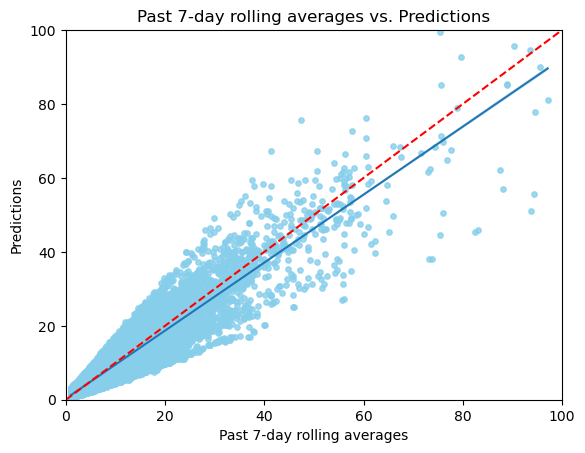

In [28]:
# 13. Past 7-day averages vs. Predictions

sns.regplot(data=hourly_rent_counts_test, x='num_rent_rolling_7', y='rent_pred', color='skyblue', line_kws={'color': None, 'linewidth': 1.5}, scatter_kws={'s':15})
plt.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1.5)

plt.title("Past 7-day rolling averages vs. Predictions")
plt.xlabel("Past 7-day rolling averages")
plt.ylabel("Predictions")
plt.xlim(0,100)
plt.ylim(0,100)

plt.savefig('images/13_rolling_averages_vs_predictions.png', bbox_inches='tight')
plt.show()

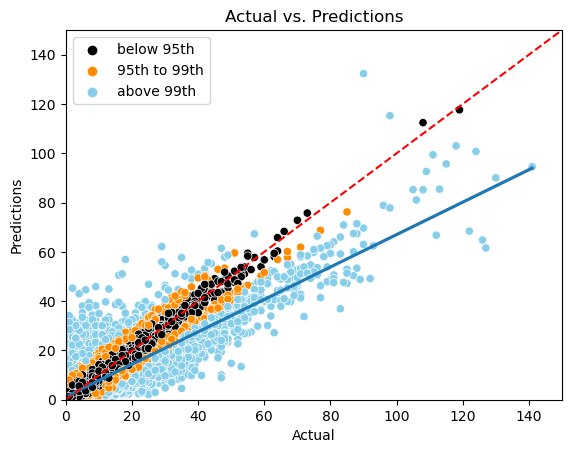

In [24]:
# 14. Actual hourly bike rentals vs. Predictions

hourly_rent_counts_test['abs_residual'] = abs(hourly_rent_counts_test['residual'])
hourly_rent_counts_test['abs_residual_quantile_95'] = hourly_rent_counts_test['abs_residual'].quantile(0.95)
hourly_rent_counts_test['abs_residual_quantile_99'] = hourly_rent_counts_test['abs_residual'].quantile(0.99)

def assign_quantile_group(row):
    if row['abs_residual'] <= row['abs_residual_quantile_95']:
        return 'below 95th'
    elif row['abs_residual'] <= row['abs_residual_quantile_99']:
        return '95th to 99th'
    else:
        return 'above 99th'

hourly_rent_counts_test['abs_residual_quantile_range'] = hourly_rent_counts_test.apply(assign_quantile_group, axis=1)


sns.scatterplot(data=hourly_rent_counts_test, x='num_rent', y='rent_pred', hue='abs_residual_quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'})
sns.regplot(data=hourly_rent_counts_test, x='num_rent', y='rent_pred', scatter=False)

plt.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1.5)

plt.xlim(0,150)
plt.ylim(0,150)
plt.title("Actual vs. Predictions")
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.legend(loc='upper left')

plt.savefig('images/14_actual_vs_predictions.png', bbox_inches='tight')
plt.show()

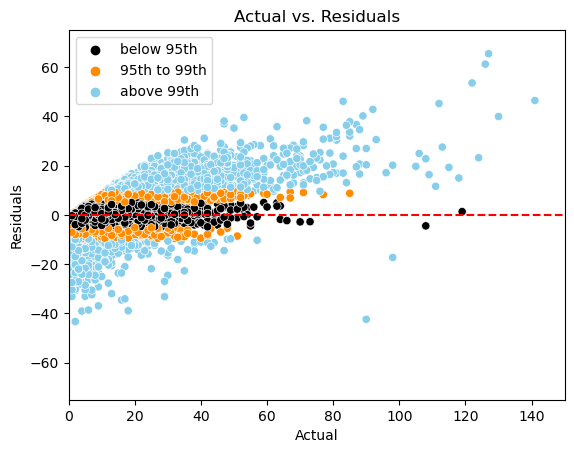

In [26]:
# 15. Actual hourly bike rentals vs. Residuals

sns.scatterplot(data=hourly_rent_counts_test, x='num_rent', y='residual', hue='abs_residual_quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'})

plt.axline((0, 0), slope=0, color='red', linestyle='--', linewidth=1.5)


plt.xlim(0,150)
plt.ylim(-75,75)
plt.title("Actual vs. Residuals")
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.legend(loc='upper left')

plt.savefig('images/15_actual_vs_residuals.png', bbox_inches='tight')
plt.show()

In [81]:
# RMSE
hourly_rent_counts_high = hourly_rent_counts_test[hourly_rent_counts_test['num_rent'] > 40]

gam_rmse = np.mean((hourly_rent_counts_test['num_rent'] - hourly_rent_counts_test['rent_pred'])**2) ** 0.5
baseline_rmse = np.mean((hourly_rent_counts_test['num_rent'] - hourly_rent_counts_test['num_rent_rolling_7'])**2) ** 0.5

gam_rmse_high = np.mean((hourly_rent_counts_high['num_rent'] - hourly_rent_counts_high['rent_pred'])**2) ** 0.5
baseline_rmse_high = np.mean((hourly_rent_counts_high['num_rent'] - hourly_rent_counts_high['num_rent_rolling_7'])**2) ** 0.5

print(f'GAM RMSE (All Data): {gam_rmse:.2f}')
print(f'Baseline RMSE (All Data): {baseline_rmse:.2f}')

print(f'GAM RMSE (Data > 40): {gam_rmse_high:.2f}')
print(f'Baseline RMSE (Data > 40): {baseline_rmse_high:.2f}')

GAM RMSE (All Data): 2.59
Baseline RMSE (All Data): 2.83
GAM RMSE (Data > 40): 18.35
Baseline RMSE (Data > 40): 18.78


In [87]:
# Correlations with actual data
hourly_rent_counts_high = hourly_rent_counts_test[hourly_rent_counts_test['num_rent'] > 40]

gam_corr = hourly_rent_counts_test['num_rent'].corr(hourly_rent_counts_test['rent_pred'])
baseline_corr = hourly_rent_counts_test['num_rent'].corr(hourly_rent_counts_test['num_rent_rolling_7'])

gam_corr_high = hourly_rent_counts_high['num_rent'].corr(hourly_rent_counts_high['rent_pred'])
baseline_corr_high = hourly_rent_counts_high['num_rent'].corr(hourly_rent_counts_high['num_rent_rolling_7'])

print(f'GAM Corr. (All Data): {gam_corr:.3f}')
print(f'Baseline Corr. (All Data): {baseline_corr:.3f}')

print(f'GAM Corr. (Data > 40): {gam_corr_high:.3f}')
print(f'Baseline Corr. (Data > 40): {baseline_corr_high:.3f}')


GAM Corr. (All Data): 0.838
Baseline Corr. (All Data): 0.800
GAM Corr. (Data > 40): 0.785
Baseline Corr. (Data > 40): 0.808


In [37]:
# folium map visualizationsall
import requests
import json
import folium
import branca.colormap as cm

r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
    
c = r.content
seoul_geo = json.loads(c)

In [43]:
# Visualize predictions and actual values for 06/28/2024 6 PM
hourly_rent_counts_18 = hourly_rent_counts_test[(hourly_rent_counts_test['hour']==18) & (hourly_rent_counts_test['rent_date']=='2024-06-28')]

range_min = min(hourly_rent_counts_18['num_rent'].min(), hourly_rent_counts_18['rent_pred'].min())
range_max = max(hourly_rent_counts_18['num_rent'].max(), hourly_rent_counts_18['rent_pred'].max())

range_rent = np.concatenate((hourly_rent_counts_18['num_rent'], hourly_rent_counts_18['rent_pred']))

In [159]:
# 16. folium map - predictions

colormap = cm.LinearColormap(
    colors=['blue', 'purple', 'white', 'yellow', 'orange', 'red'],
    vmin=range_min,
    vmax=range_max, 
    index= np.quantile(range_rent, q =[i / 5 for i in range(0, 6)])
)


m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in hourly_rent_counts_18.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['latitude'], geo_df_row['longitude']], color=colormap(geo_df_row['rent_pred'])).add_to(m)
    
colormap.caption = 'Predicted Bike Rentals'

m.add_child(colormap)

m

In [161]:
# 17. folium map - predictions

m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in hourly_rent_counts_18.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['latitude'], geo_df_row['longitude']], color=colormap(geo_df_row['num_rent'])).add_to(m)

colormap.caption = 'Actual Bike Rentals'

m.add_child(colormap)

m

In [25]:
# Calculate hourly bike returns for each station 
hourly_return_counts = bike_dat.groupby(['return_station_id_num', 'return_station_latitude', 'return_station_longitude', 'return_date', 'return_is_weekend', 'return_weekday', 'return_hour'], as_index=False).size().rename(columns={'size': 'num_return'})

# Add past 7-day rolling averages of hourly bike returns for each station
daily_return_counts = hourly_return_counts.groupby(['return_station_id_num', 'return_is_weekend', 'return_date', 'return_hour'])['num_return'].sum().reset_index()
daily_return_counts = daily_return_counts.sort_values(['return_station_id_num', 'return_date'])
daily_return_counts['num_return_rolling_7'] = (
    daily_return_counts.groupby(['return_station_id_num', 'return_hour'])['num_return']
    .transform(lambda x: x.rolling(7, min_periods=1).mean().shift(1)))

hourly_return_counts = hourly_return_counts.merge(
    daily_return_counts[['return_station_id_num', 'return_date', 'return_hour', 'num_return_rolling_7']],
    how='left',
    on=['return_station_id_num','return_date', 'return_hour'])

hourly_return_counts = hourly_return_counts[hourly_return_counts['num_return_rolling_7'].isnull()==False]

In [27]:
# Train model with first three-week data, validate it on the last week data
hourly_return_counts_train = hourly_return_counts[hourly_return_counts['return_date'] < '2024-06-24'].copy()
hourly_return_counts_test = hourly_return_counts[hourly_return_counts['return_date'] >= '2024-06-24'].copy()

#display(hourly_return_counts_train[(hourly_return_counts_train['return_station_id_num']==2739) & (hourly_return_counts_train['return_hour']==16)])
display(hourly_return_counts_train)
display(hourly_return_counts_test)

return_station_id_num  return_station_latitude  \
22                           0                37.552746   
25                           0                37.552746   
26                           0                37.552746   
27                           0                37.552746   
28                           0                37.552746   
...                        ...                      ...   
1199382                   2739                37.534390   
1199383                   2739                37.534390   
1199384                   2739                37.534390   
1199385                   2739                37.534390   
1199386                   2739                37.534390   

         return_station_longitude return_date  return_is_weekend  \
22                     126.918617  2024-06-02                  1   
25                     126.918617  2024-06-02                  1   
26                     126.918617  2024-06-02                  1   
27                     126.918617  2024-06-02                  1   
28                     126.918617  2024-06-02                  1   
...                           ...         ...                ...   
1199382                126.869598  2024-06-23                  1   
1199383                126.869598  2024-06-23                  1   
1199384                126.869598  2024-06-23                  1   
1199385                126.869598  2024-06-23                  1   
1199386                126.869598  2024-06-23                  1   

         return_weekday  return_hour  num_return  num_return_rolling_7  
22                    6            1           1              1.000000  
25                    6            5           1              2.000000  
26                    6            6           2              1.000000  
27                    6            7           1              2.000000  
28                    6            8           1              1.000000  
...                 ...          ...         ...                   ...  
1199382               6           19           8             18.571429  
1199383               6           20           7             18.571429  
1199384               6           21           9             17.142857  
1199385               6           22           3             20.714286  
1199386               6           23           4             10.000000  

[861668 rows x 9 columns]

return_station_id_num  return_station_latitude  \
455                          0                37.552746   
456                          0                37.552746   
457                          0                37.552746   
458                          0                37.552746   
459                          0                37.552746   
...                        ...                      ...   
1199528                   2739                37.534390   
1199529                   2739                37.534390   
1199530                   2739                37.534390   
1199531                   2739                37.534390   
1199532                   2739                37.534390   

         return_station_longitude return_date  return_is_weekend  \
455                    126.918617  2024-06-24                  0   
456                    126.918617  2024-06-24                  0   
457                    126.918617  2024-06-24                  0   
458                    126.918617  2024-06-24                  0   
459                    126.918617  2024-06-24                  0   
...                           ...         ...                ...   
1199528                126.869598  2024-06-30                  1   
1199529                126.869598  2024-06-30                  1   
1199530                126.869598  2024-06-30                  1   
1199531                126.869598  2024-06-30                  1   
1199532                126.869598  2024-07-01                  0   

         return_weekday  return_hour  num_return  num_return_rolling_7  
455                   0            1           1              3.000000  
456                   0            6           1              1.142857  
457                   0            7           4              2.142857  
458                   0            8           4              4.857143  
459                   0            9           8              4.857143  
...                 ...          ...         ...                   ...  
1199528               6           20          13             15.000000  
1199529               6           21          19             17.857143  
1199530               6           22          18             19.714286  
1199531               6           23          11              7.142857  
1199532               0            0           2              7.857143  

[273889 rows x 9 columns]

In [29]:
# GAM with Poisson distribution of response variables, hourly bike returns
# interactions between latitudes and longitudes of stations
# factor term of weekends or not
# smoothing terms of hours and 7-day rolling averages of bike returns

gam_return = PoissonGAM(te(0,1) + s(2) + s(3) + s(3, by=2) + s(4))
gam_return.fit(hourly_return_counts_train[['return_station_latitude', 'return_station_longitude', 'return_weekday', 'return_hour', 'num_return_rolling_7']], hourly_return_counts_train['num_return'])

gam_return.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    117.8398
Link Function:                          LogLink Log Likelihood:                              -1729231.0325
Number of Samples:                       861668 AIC:                                          3458697.7445
                                                AICc:                                         3458697.7775
                                                UBRE:                                               3.1118
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6812
Feature Function                  Lam

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25736\3839834363.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_return.summary()


In [31]:
# Make predictions on the test set
hourly_return_counts_test['return_pred'] = gam_return.predict(hourly_return_counts_test[['return_station_latitude', 'return_station_longitude', 'return_weekday', 'return_hour', 'num_return_rolling_7']])
hourly_return_counts_test['residual'] = hourly_return_counts_test['num_return'] - hourly_return_counts_test['return_pred']

hourly_return_counts_test = hourly_return_counts_test.rename(columns={'return_station_id_num': 'station_id_num', 'return_hour':'hour', 'return_station_latitude':'latitude', 'return_station_longitude':'longitude'})

hourly_return_counts_test

station_id_num   latitude   longitude return_date  return_is_weekend  \
455                   0  37.552746  126.918617  2024-06-24                  0   
456                   0  37.552746  126.918617  2024-06-24                  0   
457                   0  37.552746  126.918617  2024-06-24                  0   
458                   0  37.552746  126.918617  2024-06-24                  0   
459                   0  37.552746  126.918617  2024-06-24                  0   
...                 ...        ...         ...         ...                ...   
1199528            2739  37.534390  126.869598  2024-06-30                  1   
1199529            2739  37.534390  126.869598  2024-06-30                  1   
1199530            2739  37.534390  126.869598  2024-06-30                  1   
1199531            2739  37.534390  126.869598  2024-06-30                  1   
1199532            2739  37.534390  126.869598  2024-07-01                  0   

         return_weekday  hour  num_return  num_return_rolling_7  return_pred  \
455                   0     1           1              3.000000     2.254523   
456                   0     6           1              1.142857     2.079850   
457                   0     7           4              2.142857     3.955240   
458                   0     8           4              4.857143     8.392674   
459                   0     9           8              4.857143     5.765439   
...                 ...   ...         ...                   ...          ...   
1199528               6    20          13             15.000000    12.982655   
1199529               6    21          19             17.857143    15.113007   
1199530               6    22          18             19.714286    15.450989   
1199531               6    23          11              7.142857     6.208599   
1199532               0     0           2              7.857143     6.210160   

         residual  
455     -1.254523  
456     -1.079850  
457      0.044760  
458     -4.392674  
459      2.234561  
...           ...  
1199528  0.017345  
1199529  3.886993  
1199530  2.549011  
1199531  4.791401  
1199532 -4.210160  

[273889 rows x 11 columns]

In [91]:
# Visualize predictions and actual values for 06/28/2024 6 PM
hourly_return_counts_18 = hourly_return_counts_test[(hourly_return_counts_test['hour']==10) & (hourly_return_counts_test['return_date']=='2024-06-26')]

range_min = min(hourly_return_counts_18['num_return'].min(), hourly_return_counts_18['return_pred'].min())
range_max = max(hourly_return_counts_18['num_return'].max(), hourly_return_counts_18['return_pred'].max())

range_return = np.concatenate((hourly_return_counts_18['num_return'], hourly_return_counts_18['return_pred']))

In [93]:
# 16. folium map - predictions

colormap = cm.LinearColormap(
    colors=['blue', 'purple', 'white', 'yellow', 'orange', 'red'],
    vmin=range_min,
    vmax=range_max, 
    index= np.quantile(range_return, q =[i / 5 for i in range(0, 6)])
)


m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in hourly_return_counts_18.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['latitude'], geo_df_row['longitude']], color=colormap(geo_df_row['return_pred'])).add_to(m)
    
colormap.caption = 'Predicted Bike Returns'

m.add_child(colormap)

m

In [87]:
hourly_diff_18 = hourly_rent_counts_18.merge(hourly_return_counts_18[['station_id_num', 'return_pred']], how='left', on='station_id_num')
hourly_diff_18['diff'] = hourly_diff_18['return_pred'] - hourly_diff_18['rent_pred']
hourly_diff_18 = hourly_diff_18[hourly_diff_18['diff'].isna()==False]


range_diff_min = hourly_diff_18['diff'].min()
range_diff_max = hourly_diff_18['diff'].max()

range_diff = hourly_diff_18['diff']

hourly_diff_18

station_id_num   latitude   longitude   rent_date  rent_is_weekend  \
0                  0  37.552746  126.918617  2024-06-28                0   
1                  1  37.510380  126.866798  2024-06-28                0   
2                  2  37.529900  126.876541  2024-06-28                0   
3                  3  37.539551  126.828300  2024-06-28                0   
4                  5  37.513950  126.856056  2024-06-28                0   
...              ...        ...         ...         ...              ...   
2405            2734  37.549061  126.954178  2024-06-28                0   
2406            2735  37.521511  126.857384  2024-06-28                0   
2407            2736  37.529163  126.872749  2024-06-28                0   
2408            2737  37.510597  126.857323  2024-06-28                0   
2409            2739  37.534390  126.869598  2024-06-28                0   

      rent_weekday  hour  num_rent  num_rent_rolling_7  rent_pred  residual  \
0                4    18         7            8.571429   8.528911 -1.528911   
1                4    18         9            6.142857   6.643269  2.356731   
2                4    18        16           23.000000  22.702939 -6.702939   
3                4    18        10            3.428571   3.528760  6.471240   
4                4    18        12           10.285714  10.317893  1.682107   
...            ...   ...       ...                 ...        ...       ...   
2405             4    18         2            5.857143   5.549608 -3.549608   
2406             4    18         6            4.571429   4.963932  1.036068   
2407             4    18        21           17.428571  17.215151  3.784849   
2408             4    18         1            2.571429   3.140896 -2.140896   
2409             4    18        14           13.857143  13.798808  0.201192   

      return_pred       diff  
0        5.313676  -3.215235  
1        8.873274   2.230005  
2       15.861558  -6.841382  
3        4.081919   0.553158  
4       15.045152   4.727260  
...           ...        ...  
2405     6.781934   1.232326  
2406     8.040686   3.076754  
2407     5.764165 -11.450986  
2408     1.801507  -1.339389  
2409    20.423131   6.624323  

[2236 rows x 13 columns]

In [89]:
# 16. folium map - differences

colormap = cm.LinearColormap(
    colors=['blue', 'purple', 'white', 'yellow', 'orange', 'red'],
    vmin=range_diff_min,
    vmax=range_diff_max, 
    index= np.quantile(sorted(range_diff), q =[i / 5 for i in range(0, 6)])
)


m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in hourly_diff_18.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['latitude'], geo_df_row['longitude']], color=colormap(geo_df_row['diff'])).add_to(m)
    
colormap.caption = 'Differences'

m.add_child(colormap)

m

In [ ]:
hourly_diff = hourly_rent_counts.merge(hourly_return_counts[['station_id_num', 'return_pred']], how='left', on='station_id_num')